<a href="https://colab.research.google.com/github/bongbolobong/-/blob/main/Sartorius_mmdet_Cell_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ref 
Create COCO dataset - https://www.kaggle.com/vexxingbanana/sartorius-coco-dataset-notebook


## MMdet 설정해야 하는 부분 
- Custmize Dataset ( COCO format, middle format)
- Custmize Data Pipeline
- Customize Model
- Customize Runtime Settings 
- Customize Losses
- Finetuning Models

In [ ]:
# # Check nvcc version
# !nvcc -V
# # Check GCC version
# !gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!pip install mmdet
!pip install mmsegmentation
!pip install albumentations==0.4.6

!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

!pip install Pillow==7.0.0


#!pip install iterative-stratification
#!pip install kaggle


In [ ]:
import re
import shutil
import os
from pathlib import Path


from itertools import groupby
import numpy as np
import numpy.random
import random
import cupy as cp
import gc
import pandas as pd
import json
import glob


from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2


import pickle #  텍스트 이외의 자료형(list, class,dict)등 을 파일로 저장할때 사용 

import cv2
from multiprocessing import Pool
from pycocotools.coco import COCO
from pycocotools import mask
from pycocotools import mask as mutils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision

import mmdet
import mmcv
from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector, init_detector, show_result_pyplot, set_random_seed




# seed 고정 
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2021)

Torch version:1.10.0+cu111
cuda version: 11.1


In [40]:
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Torch version:1.10.0+cu111
cuda version: 11.1


In [41]:
DEVICE

device(type='cuda')

In [ ]:
from os import chdir as cd
cd ('/content/')


In [ ]:
!mkdir Sartorius
os.mkdir ('/content/Sartorius/train')
os.mkdir ('/content/Sartorius/test')
os.mkdir ('/content/Sartorius/train_npz')

In [ ]:
os.listdir('/content/drive/MyDrive/data/kaggle_Sartorius/')

['train.csv.zip',
 'test.zip',
 'train.zip',
 'npz.zip',
 'mmdet_val.pkl',
 'mmdet_trn.pkl',
 'mmdet_full.pkl']

In [ ]:
cd ('/content/Sartorius/train')
!unzip -qq "/content/drive/MyDrive/data/kaggle_Sartorius/train.zip"

cd ('/content/Sartorius/train_npz')
!unzip -qq "/content/drive/MyDrive/data/kaggle_Sartorius/npz.zip"

cd ('/content/Sartorius/test')
!unzip -qq "/content/drive/MyDrive/data/kaggle_Sartorius/test.zip"

cd ('/content/Sartorius')
!unzip -qq "/content/drive/MyDrive/data/kaggle_Sartorius/train.csv.zip"

cd ('/content/mmdetection')
!mkdir checkpoints


In [ ]:
cd ('/content')
!mkdir '/content/Sartorius_config'
!mkdir '/content/mmdetection/Sartorius_config'
!mkdir '/content/output'

In [ ]:
# #checkpoint 다운 
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2021-12-08 07:30:00--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.59
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco’

/content/mmdetectio 100%[===================>] 242.32M  6.65MB/s    in 30s     

2021-12-08 07:30:31 (7.99 MB/s) - ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco’ saved [254089599/254089599]



In [ ]:
#경로 설정
conf_name = "mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco" # /content/mmdetection/configs/resnest/faster_rcnn_s50_fpn_syncbn-backbone+head_mstrain-range_1x_coco.py

cell_mask_dir = '/content/Sartorius/train_npz/'    
ROOT = '/content/Sartorius/'

train_or_test = 'train'
img_dir = f'/content/mmdet_{train_or_test}'
!mkdir -p {img_dir}


In [ ]:
df = pd.read_csv(ROOT+'train.csv')
df['image_path'] = ROOT + '/train/' + df['id'] + '.png'


In [ ]:
tmp_df = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)
# id 컬럼으로 group by 진행한 다음 annotation 컬럼에 대해  
#tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)

In [ ]:
# 중복값 제거할때  사용 - unique()는 array 반환 , drop_duplicate(subset=[중복 체크할 columns])는 series 반환 
tmp_df = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)
# id 컬럼으로 group by 진행한 다음 annotation 컬럼에 대해 각각 리스트로 변환 해서 합침  즉 id수만큼 리스트 생성 
# groupby():그룹객체 만듦  agg():여러개의 함수를 여러 열에 적용
tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)
df = tmp_df.copy()
df['label'] = df.cell_type.map({v:k for k, v in enumerate(df.cell_type.unique())})


In [ ]:
# direct load mask from dataframe --> slower
def rle2mask(rle, shape=[520, 704]):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def get_mask(image_id):
    """thanks to @onodera"""
    mask_df   = df[df.id == image_id]
    gt_masks = [rle2mask(rle) for rle in mask_df["annotation"].tolist()[0]]
    gt_masks = np.stack(gt_masks)
    return gt_masks

In [ ]:
#get_rles_from_mask  결과 확인 
# pp =get_rles_from_mask('0030fd0e6378')
# pp[:3]

In [ ]:
# convert segmentation mask image to run length encoding
# npz 파일 : numpy array를 이진수로 저장한 파일  계산된 값을 저장해놓기 때문에 매번 계산할 필요 없어서 편리함  pickle보다 적은공간을 차지하고 빠름 
# 사용된 npz 파일은 instance id 별로 masking 되어있는 파일
def get_rles_from_mask(image_id):
    mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0'] #[arr_0]을 해주면 value값 
    rle_list = []
    mask_ids = np.unique(mask) # 2차원 array에서 고유값을 검색하고 정렬하여 1차원 array로 반환  
    for val in mask_ids: 
        if val == 0: # 0이면 객체가 아니고 배경이므로 continue 
            continue
        binary_mask = np.where(mask == val, 1, 0).astype(bool)  # mask 값이 val이랑 같으면 1 그렇지 않으면 0  
        rle = coco_rle_encode(binary_mask) #binary_mask 는 2차원 array
        rle_list.append(rle)
    return rle_list, mask.shape[0], mask.shape[1] #  rle_list([counts:[RLE] size:[H,W]],....[] ) , H, W 

def coco_rle_encode(mask):
    rle = {'counts': [], 'size': list(mask.shape)} #size는 왜 필요한지 이해 못 함 
    counts = []
    for i, (value, elements) in enumerate(groupby(mask.ravel(order='F'))): #ravel,reshape 1차원으로 변환 (flatten) 
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    rle['counts'] = counts
    return rle


'''
MMDet 사용하려면 코코 포멧이나 PASCAL 포멧, Middle 포멧으로 변경해야 함 ,
학습중 변경하는것 보다는 학습전에 미리 변경해두는것을 권장 
MS -COCO  : JSON 포맷인 한 개의 파일로 구성됨 ( 한 라인으로)
MS -COCO 구성은  
- info
- license
- images
- annotations
- categories
images, annotations, categories는 필수로 작성해야함

베이스코드에서는 middle format 사용 https://mmdetection.readthedocs.io/en/latest/tutorials/customize_dataset.html
middle format 하나의 dict는 하나의 이미지에 대응 
'''
# mmdet custom dataset generator 
def mk_mmdet_custom_data(image_id):
    rles, height, width = get_rles_from_mask(image_id) # rle_list(counts:[RLE] size:[H,W] ) , H, W 
    if len(rles) == 0: 
        return {
            'filename': image_id+'.png',
            'width': width,
            'height': height,
            'ann': {}
        }
    rles = mutils.frPyObjects(rles, height, width) # masks = mutils.decode(rles)
    bboxes = mutils.toBbox(rles)
    bboxes[:, 2] += bboxes[:, 0]
    bboxes[:, 3] += bboxes[:, 1]
    return {
        'filename': image_id+'.png',
        'width': width,
        'height': height,
        'ann':
            {
                'bboxes': np.array(bboxes, dtype=np.float32), #np.ndarray (k,4)
                'labels': np.zeros(len(bboxes)), # dummy data.(will be replaced later)  np.ndarray (k,4)
                'masks': rles # dict형태로 들어가나 ?
            }
    }

# print utility from public notebook
def print_masked_img(image_id, mask):
    img   = load_RGBY_image(image_id, train_or_test)[...,0]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img2  = clahe.apply(img)
    img3  = cv2.equalizeHist(img)
    img   = np.stack([img, img2, img3],axis=-1)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask,cmap='inferno')
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='inferno')
    plt.title('Image + Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# image loader, using rgb only here
def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    img = read_img(image_id, train_or_test, image_size) # 이미지 resize 되거나 normalization 적용된 이미지 반환 Shape: (H,W,C)
    # 배열들의 shape 동일할 경우 np,stack 사용 가능 https://everyday-image-processing.tistory.com/87
    stacked_images = np.stack([img for _ in range(3)],axis=-1)  # ? 이해 못 함 
    return stacked_images

# 
def read_img(image_id, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED) # 이미지 불러오기 , IMREAD_UNCHANGED:이미지 원본사용 
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
    return img

# make annotation helper called multi processes
def mk_ann(idx):
    image_id = df.iloc[idx]['id'] 
    anno = mk_mmdet_custom_data(image_id)
    img = load_RGBY_image(image_id, train_or_test)
    cv2.imwrite(f'{img_dir}/{image_id}.png', img) # 이거 왜 필요 ?
    return anno, idx, image_id

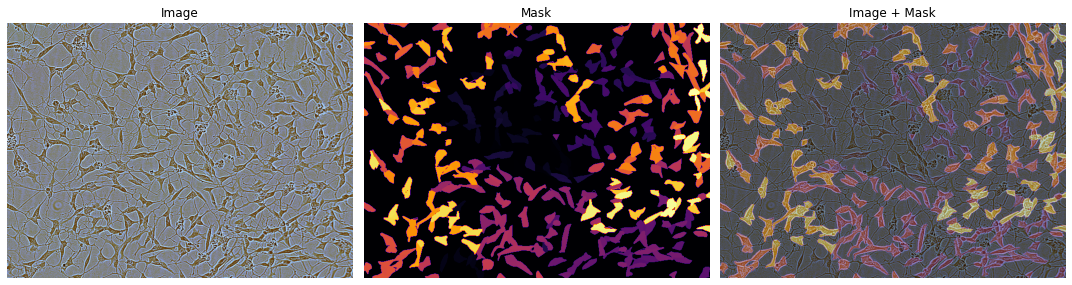

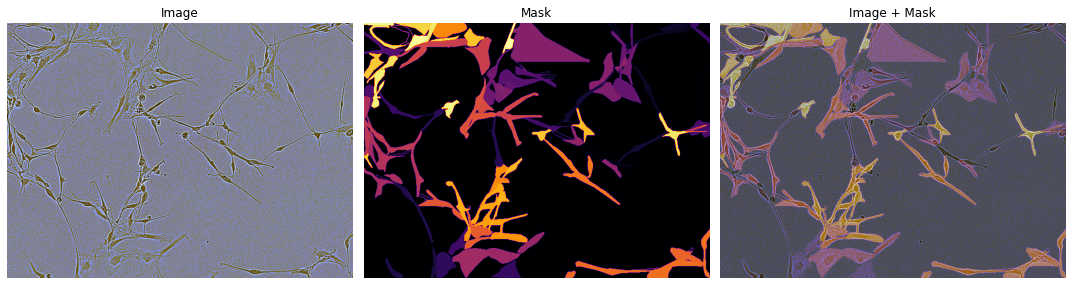

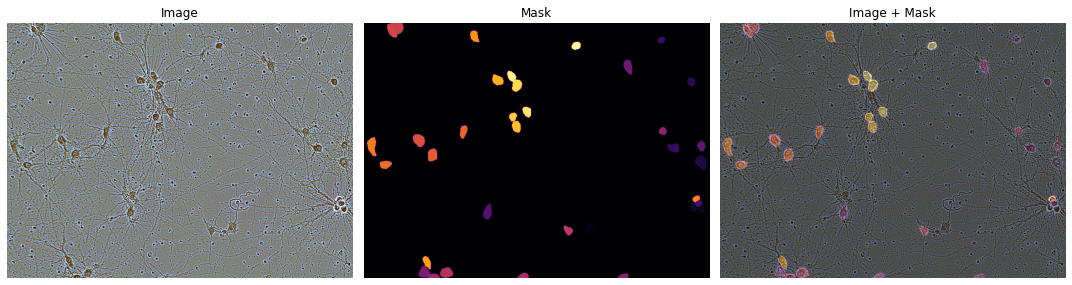

In [ ]:
for idx in range(3):
    image_id = df.iloc[idx]['id']
    cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    print_masked_img(image_id, cell_mask)

## Generate Data for MMDet (Middle format)

> 들여쓴 블록



In [ ]:
# Customdataset 형태로 변환하는 부분 
from multiprocessing import Pool

# this part would take several hours, depends on your CPU power.
MAX_THRE = 4 # total CPU
p = Pool(processes=MAX_THRE)
annos = []
len_df = len(df)
#iterable에 대해 동일한 함수를 멀티프로세싱을 이용하여 처리하고자 할 때 사용한다.
for anno, idx, image_id in tqdm(p.imap(mk_ann, range(len(df))), total=len(df)): #imap(func, iterable[, chunksize])¶
    if len(anno['ann']) > 0:
        annos.append(anno)

  0%|          | 0/606 [00:00<?, ?it/s]

In [ ]:
df.set_index('id').to_dict()['label']

In [ ]:
# train val dataset split 
lbl_cnt_dict = df.set_index('id').to_dict()['label'] # id:label 구조
trn_annos = []
val_annos = []
val_len = int(len(annos)*0.01)
for idx in range(len(annos)):
    ann = annos[idx]
    filename  = ann['filename'].replace('.jpg','').replace('.png','')
    label_ids = [0] # lbl_cnt_dict[filename]
    len_ann   = len(ann['ann']['bboxes'])
    bboxes    = ann['ann']['bboxes']
    masks     = ann['ann']['masks']
    # asign image level labels to each cells
    for cnt, label_id in enumerate(label_ids):
        label_id = int(label_id)
        if cnt == 0:
            ann['ann']['labels'] = np.full(len_ann, label_id)
        else:
            ann['ann']['bboxes'] = np.concatenate([ann['ann']['bboxes'],bboxes])
            ann['ann']['labels'] = np.concatenate([ann['ann']['labels'],np.full(len_ann, label_id)])
            ann['ann']['masks'] = ann['ann']['masks'] + masks    
    if idx < val_len:
        val_annos.append(ann)
    else:
        trn_annos.append(ann)

In [ ]:
with open(f'/content/drive/MyDrive/data/kaggle_Sartorius/mmdet_full.pkl', 'wb') as f:
    pickle.dump(annos, f) #데이터 입력  - data, file   
with open(f'/content/drive/MyDrive/data/kaggle_Sartorius/mmdet_trn.pkl', 'wb') as f:
    pickle.dump(trn_annos, f)
with open(f'/content/drive/MyDrive/data/kaggle_Sartorius/mmdet_val.pkl', 'wb') as f:
    pickle.dump(val_annos, f)

## Custom Config

In [ ]:
# cp: 복사 -r:하위 디렉토리와 파일 모두 복사 옵션  ,   cp -r 원본파일, 목적지 
#!cp -r /content/mmdetection

In [ ]:
#!ls -l ../mmdetection/configs/sartorius/

In [ ]:
!cp -r content/sartorius-mmdet-config-ds/sartorius /content/mmdetection/configs/sartorius

cp: cannot stat 'content/sartorius-mmdet-config-ds/sartorius': No such file or directory


## Congif 파일 수정 부분
Customdataset이 완료되면 congif file 수정 필요 


## config 대분류

### dataset
dataset의 type(CustomDataset, CocoDataset등), train/val/test Dataset 유형, data_root, train/val/test Dataset의 주요 파라미터 설정(type, ann_file, img_prefix, pipeline 등)



### model
Object Detection Model 의 backbone, neck, dense head, roi extractor, roi head 주요 영역별로 세부 설정.



### schedule
optimizer 유형 설정(SGD, Adam, Rmsprop등), 최초 learning 설정
학습 중 동적 Learning rate 적용 정책 설정( step, cyclic, CosineAnnealing등)
train 시 epochs 횟수

### run time
주로 hook(callback)관련 설정.
학습 중 checkpoint 파일, log 파일 생성을 위한 interval epochs수

https://velog.io/@dust_potato/MM-Detection-Config-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-4

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ




mask rcnn s50 fpn _sy~ 
-  mask rcnn r50 fpn 1x_coco
 -  mask_rcnn_r50_fpn.py
    - sartorius_instance.py
    - schedule_1x.py
    - default_runtime.py

https://github.com/open-mmlab/mmdetection/blob/3545915bf14f2acbb5def6355873f7a773149e62/configs/_base_/models/mask_rcnn_r50_fpn.py

 nms=dict(type='nms', iou_threshold=0.7),,max_per_img 빠진 부분 채워 넣었음 

###  CUSTOMIZE MODELS


MMDet은 기본적으로 모델을 5가지 요소로 구분한다.

◾ Backbone - 피처맵을 추출하기 위한 FCN 네트워크 (ex. ResNet, MobileNet)

◾ neck - backbone과 head 사이를 연결하는 요소 (ex. FPN, PAFPN)

◾ head - 구체적인 태스크를 위한 요소 (ex. bbox prediction, mask prediction)

◾ roi extractor - 피처맵으로부터 RoI 특징을 추출하는 부분 (ex. RoI Align)

◾ loss - loss를 계산하기 위한 head의 구성 요소 (ex. FocalLoss, L1Loss, GHMLoss)




https://mmdetection.readthedocs.io/en/latest/tutorials/customize_models.html#

In [ ]:
%%writefile /content/mmdetection/configs/_base_/models/mask_rcnn_r50_fpn.py
# base
# model settings
model = dict(
    type='MaskRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
        mask_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=14, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        mask_head=dict(
            type='FCNMaskHead',
            num_convs=4,
            in_channels=256,
            conv_out_channels=256,
            num_classes=1,
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0))))
# model training and testing settings
train_cfg = dict(
    rpn=dict(
        assigner=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.7,
            neg_iou_thr=0.3,
            min_pos_iou=0.3,
            match_low_quality=True,
            ignore_iof_thr=-1),
        sampler=dict(
            type='RandomSampler',
            num=256,
            pos_fraction=0.5,
            neg_pos_ub=-1,
            add_gt_as_proposals=False),
        allowed_border=-1,
        pos_weight=-1,
        debug=False),
    rpn_proposal=dict(
        nms_across_levels=False,
        nms_pre=2000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        max_per_img=100,
        nms=dict(type='nms', iou_threshold=0.7),
        min_bbox_size=0),
    rcnn=dict(
        assigner=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.5,
            neg_iou_thr=0.5,
            min_pos_iou=0.5,
            match_low_quality=True,
            ignore_iof_thr=-1),
        sampler=dict(
            type='RandomSampler',
            num=512,
            pos_fraction=0.25,
            neg_pos_ub=-1,
            add_gt_as_proposals=True),
        mask_size=28,
        pos_weight=-1,
        debug=False))
      
test_cfg = dict(
    rpn=dict(
        nms_across_levels=False,
        nms_pre=1000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        max_per_img=100,
        nms=dict(type='nms', iou_threshold=0.7),
        min_bbox_size=0),
    rcnn=dict(
        score_thr=0.05,
        nms=dict(type='nms', iou_threshold=0.5),
        max_per_img=100,
        mask_thr_binary=0.5))

Overwriting /content/mmdetection/configs/_base_/models/mask_rcnn_r50_fpn.py


### Customize Data Pipelines

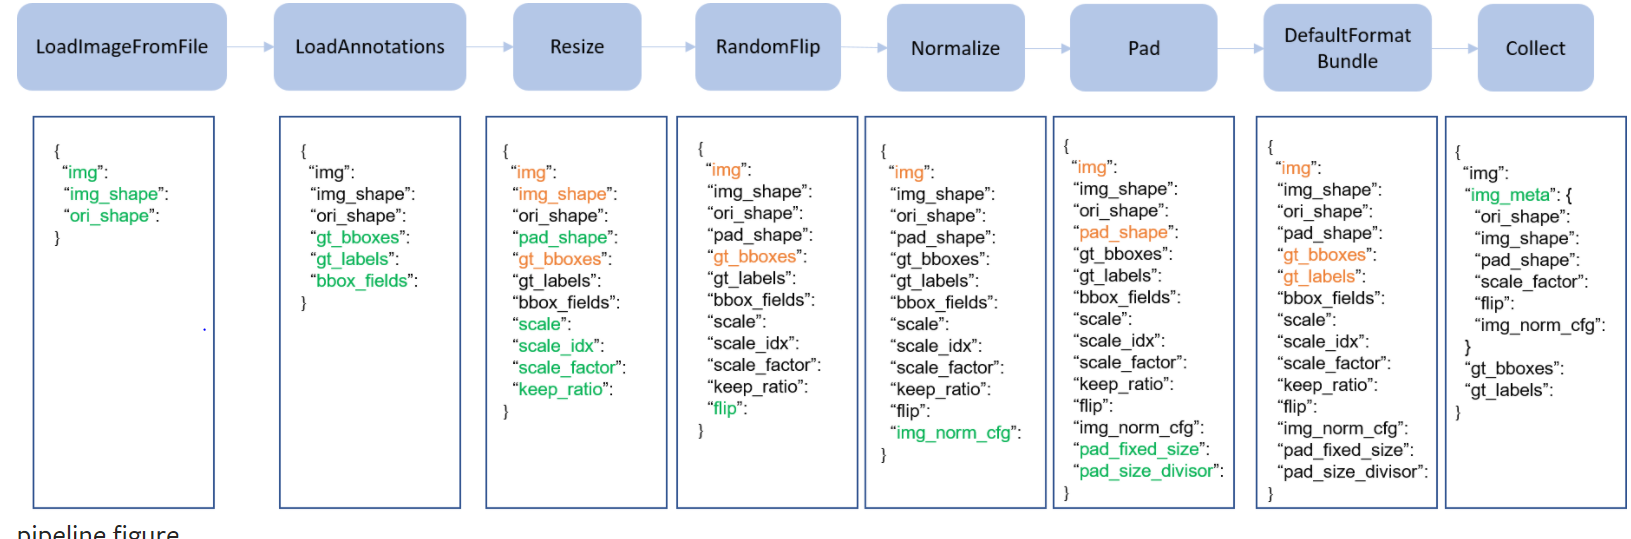


In [ ]:
#dataset config
#ref https://mmdetection.readthedocs.io/en/latest/api.html#mmdet-datasets
%%writefile /content/mmdetection/Sartorius_config/sartorius_instance.py
dataset_type = 'CustomDataset'
data_root = '/content/drive/MyDrive/data/kaggle_Sartorius/' # 수정 
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True), # Whether to parse and load the bbox,mask annotation. Default: True 
    dict(type='Resize', img_scale=[(1333, 1333), (1024, 1024)], keep_ratio=True), ## 
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32), # The divisor of padded size.
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1280, 1280),
        flip=True,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=2, #Number of training samples on each GPU, i.e., batch size of each GPU.
    workers_per_gpu=2, # How many subprocesses to use for data loading for each GPU.
    train=dict(
        type=dataset_type,
        ann_file=data_root + 'mmdet_trn.pkl',
        img_prefix='/content/Sartorius/train/', # 수정
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'mmdet_val.pkl',
        img_prefix='/content/Sartorius/train/', #수정 
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'mmdet_tst.pkl',
        img_prefix='/content/Sartorius/test', #수정 
        pipeline=test_pipeline))
evaluation = dict(interval=1000) # skip evaluation

Writing /content/mmdetection/Sartorius_config/sartorius_instance.py


In [ ]:
%%writefile /content/mmdetection/Sartorius_config/schedule_1x.py
 
# optimizer
optimizer = dict(type='Adam', lr=0.0003, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
# learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11])
total_epochs = 1

Writing /content/mmdetection/Sartorius_config/schedule_1x.py


Modify default runtime hooks
There are some common hooks that are not registered through custom_hooks, they are

log_config

checkpoint_config

evaluation

lr_config

optimizer_config

momentum_config

In [ ]:
%%writefile /content/mmdetection/Sartorius_config/default_runtime.py
checkpoint_config = dict(interval=1)
# yapf:disable
log_config = dict(
    interval=50,
    hooks=[
        dict(type='TextLoggerHook'),
        # dict(type='TensorboardLoggerHook')
    ])
# yapf:enable
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]

Writing /content/mmdetection/Sartorius_config/default_runtime.py


In [ ]:
%%writefile /content/mmdetection/configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py
_base_ = [
    '/content/mmdetection/configs/_base_/models/mask_rcnn_r50_fpn.py',
    '/content/mmdetection/Sartorius_config/sartorius_instance.py',
    '/content/mmdetection/Sartorius_config/schedule_1x.py',
    '/content/mmdetection/Sartorius_config/default_runtime.py'
    
]

Overwriting /content/mmdetection/configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py


In [ ]:
%%writefile /content/mmdetection/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py
_base_ = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    pretrained='open-mmlab://resnest50',
    backbone=dict(
        type='ResNeSt',
        stem_channels=64,
        depth=50,
        
        radix=2,
        reduction_factor=4,
        avg_down_stride=True,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=norm_cfg,
        norm_eval=False,
        style='pytorch'),
    roi_head=dict(
        bbox_head=dict(
            type='Shared4Conv1FCBBoxHead',
            conv_out_channels=256,
            norm_cfg=norm_cfg),
        mask_head=dict(norm_cfg=norm_cfg)))
# # use ResNeSt img_norm
img_norm_cfg = dict(
    mean=[123.68, 116.779, 103.939], std=[58.393, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='LoadAnnotations',
        with_bbox=True,
        with_mask=True,
        poly2mask=True),
    dict(
        type='Resize',
        img_scale=[(1333, 1333), (1280, 1280), (1024, 1024)],
        multiscale_mode='value',
        keep_ratio=True),
    dict(type='RandomFlip', direction=['horizontal', 'vertical'], flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1280, 1280),
        flip=True,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip',direction=['horizontal', 'vertical']),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=2, #  Number of training samples on each GPU, i.e., batch size of each GPU.
    train=dict(pipeline=train_pipeline),
    val=dict(pipeline=test_pipeline),
    test=dict(pipeline=test_pipeline))

Writing /content/mmdetection/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py


In [ ]:
src = '/content/Sartorius_config/default_runtime.py'
dst = '/content/mmdetection/Sartorius_config'
shutil.copy(src,dst)

src ='/content/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py'
shutil.copy(src,dst)

src ='/content/Sartorius_config/sartorius_instance.py'
shutil.copy(src,dst)

src = '/content/Sartorius_config/schedule_1x.py'
shutil.copy(src,dst)

'/content/mmdetection/Sartorius_config/schedule_1x.py'

In [ ]:
config =  f'/content/mmdetection/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py'

# using --no-validate to avoid some errors for custom dataset metrics

#--cfg-options: if specified, the key-value pair optional cfg will be merged into config file
additional_conf = '--cfg-options' # --no-validate
additional_conf += f' work_dir=/content/Sartorius'
additional_conf += f' optimizer.lr=0.0025'
cmd = f'bash -x /content/mmdetection/tools/dist_train.sh {config} 1 {additional_conf}'
!cd ../mmdetection;  {cmd}

/bin/bash: line 0: cd: ../mmdetection: No such file or directory
+ CONFIG=/content/mmdetection/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py
+ GPUS=1
+ PORT=29500
++ dirname /content/mmdetection/tools/dist_train.sh
++ dirname /content/mmdetection/tools/dist_train.sh
+ PYTHONPATH=/content/mmdetection/tools/..:/env/python
+ python -m torch.distributed.launch --nproc_per_node=1 --master_port=29500 /content/mmdetection/tools/train.py /content/mmdetection/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py --launcher pytorch --cfg-options work_dir=/content/Sartorius optimizer.lr=0.0025
/usr/local/lib/python3.7/dist-packages/torch/distributed/launch.py:186: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See

학습 중 tcmalloc: large alloc 1166450688 bytes 와 같은 warning 메시지가 뜸. 
TCMALLOC_LARGE_ALLOC_REPORT_THRESHOLD 는 초기 값이  1073741824 bytes. ~1GB로 설정된 환경변수이다.   따라서 이는 메모기 할당이 1GB 이상일 경우 발생하는   경고   - https://stackoverflow.com/questions/52351611/is-tcmalloc-large-alloc-a-warning-or-error-in-python/52399665

  assert not (init_cfg and pretrained), \
            'init_cfg and pretrained cannot be specified at the same time'

model - 상속 - 상속
base 전부 절대경로로 수정하기


In [ ]:
# # 절대경로 
# cfg = Config.fromfile('/content/mmdetection/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py') 
# print(cfg.pretty_text)


# meta = dict()
# meta['config'] = cfg.pretty_text
# cfg.gpu_ids = range(1)
# cfg.work_dir = '/content/Sartoriust'
# cfg.seed = 0

# datasets = [build_dataset(cfg.data.train)]
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model.CLASSES = datasets[0].CLASSES

# mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
# train_detector(model, datasets, cfg, distributed=False, validate=True, meta=meta)

In [ ]:

# cfg = Config.fromfile('/content/Sartorius_config/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py')
# # Build dataset
# datasets = [build_dataset(cfg.data.train)]

# # Build the detector
# model = build_detector(
#     cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# # Add an attribute for visualization convenience
# model.CLASSES = datasets[0].CLASSES

# # Create work_dir
# mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# train_detector(model, datasets, cfg, distributed=False, validate=True)

Meta Data

In [ ]:
conf_name = "mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco"
model_name = 'epoch_10'
ROOT = '../input/sartorius-cell-instance-segmentation'
train_or_test = 'test'
THR = 0.50
# Test Data
df  = pd.DataFrame(glob(ROOT+f'/{train_or_test}/*'), columns=['image_path'])
df['id'] = df.image_path.map(lambda x: x.split('/')[-1].split('.')[0])
# df= df.sample(frac=20, replace=True)
display(df.head())